In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import pathlib
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sn
from kapre import STFT, Magnitude, MagnitudeToDecibel
from kapre.composed import get_melspectrogram_layer, get_log_frequency_spectrogram_layer

%matplotlib inline

seed = 30
tf.random.set_seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
data_path = '/tf/data/ADReSS-IS2020'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [4]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
        
    rolling_waveform_tensors = window(waveform, size=_*size_sec, stride=_*stride_sec)

    return rolling_waveform_tensors, label

In [7]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(100)\
                        .flat_map(lambda x,y: tf.data.Dataset.zip((
                                    tf.data.Dataset.from_tensor_slices(x), 
                                    tf.data.Dataset.from_tensor_slices([y])
                        )))\
                        .shuffle(100)
    return output_ds

In [8]:
size_sec = 30
stride_sec = 1

In [9]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


In [10]:
for spectrogram, y in train_ds.take(1):
    input_shape = spectrogram.shape
    print(input_shape)
    print(y)


(1323000,)
tf.Tensor(28, shape=(), dtype=int64)


In [11]:
batch_size = 32
train_ds_b = train_ds.batch(batch_size)
val_ds_b = val_ds.batch(batch_size)

In [12]:
print('Input shape:', input_shape)

model = models.Sequential([
    STFT(n_fft=2048, win_length=2018, hop_length=1024,
               window_name=None, pad_end=False,
               input_data_format='channels_last', 
               output_data_format='channels_last',
               input_shape=(1323000,1)),
    Magnitude(),
    MagnitudeToDecibel(),
    layers.Reshape((1291,1025)),
    layers.BatchNormalization(),
    layers.Dense(256,  activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.LSTM(128, 
                activation='tanh', 
                recurrent_activation='sigmoid', 
                recurrent_dropout=0,
                unroll=False,
                use_bias=True,
                kernel_initializer='he_normal', 
                return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                recurrent_dropout=0,
                unroll=False,
                use_bias=True,
                kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.Dense(1)
])

model.summary()

Input shape: (1323000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stft (STFT)                  (None, 1291, 1025, 1)     0         
_________________________________________________________________
magnitude (Magnitude)        (None, 1291, 1025, 1)     0         
_________________________________________________________________
magnitude_to_decibel (Magnit (None, 1291, 1025, 1)     0         
_________________________________________________________________
reshape (Reshape)            (None, 1291, 1025)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1291, 1025)        4100      
_________________________________________________________________
dense (Dense)                (None, 1291, 256)         262656    
_________________________________________________________________
dropout (Dropout)            (No

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='mse',
    metrics='mse'
)

In [14]:
EPOCHS = 10000
history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[callback]
)

Epoch 1/10000
3/3 [==============================] - 5s 867ms/step - loss: 596.7336 - mse: 596.7336 - val_loss: 569.1003 - val_mse: 569.1003
Epoch 2/10000
3/3 [==============================] - 1s 211ms/step - loss: 550.5321 - mse: 550.5321 - val_loss: 541.9237 - val_mse: 541.9237
Epoch 3/10000
3/3 [==============================] - 1s 213ms/step - loss: 538.1422 - mse: 538.1422 - val_loss: 513.1115 - val_mse: 513.1115
Epoch 4/10000
3/3 [==============================] - 1s 215ms/step - loss: 521.7508 - mse: 521.7508 - val_loss: 483.2199 - val_mse: 483.2199
Epoch 5/10000
3/3 [==============================] - 1s 200ms/step - loss: 481.1594 - mse: 481.1594 - val_loss: 460.8921 - val_mse: 460.8921
Epoch 6/10000
3/3 [==============================] - 1s 209ms/step - loss: 453.8316 - mse: 453.8316 - val_loss: 424.5221 - val_mse: 424.5221
Epoch 7/10000
3/3 [==============================] - 1s 207ms/step - loss: 414.0198 - mse: 414.0198 - val_loss: 394.4042 - val_mse: 394.4042
Epoch 8/10000

3/3 [==============================] - 1s 212ms/step - loss: 83.2667 - mse: 83.2667 - val_loss: 43.8300 - val_mse: 43.8300
Epoch 60/10000
3/3 [==============================] - 1s 204ms/step - loss: 65.3315 - mse: 65.3315 - val_loss: 43.9832 - val_mse: 43.9832
Epoch 61/10000
3/3 [==============================] - 1s 199ms/step - loss: 90.6276 - mse: 90.6276 - val_loss: 44.2871 - val_mse: 44.2871
Epoch 62/10000
3/3 [==============================] - 1s 208ms/step - loss: 85.3062 - mse: 85.3062 - val_loss: 44.5762 - val_mse: 44.5762
Epoch 63/10000
3/3 [==============================] - 1s 212ms/step - loss: 85.4441 - mse: 85.4441 - val_loss: 44.9362 - val_mse: 44.9362
Epoch 64/10000
3/3 [==============================] - 1s 204ms/step - loss: 89.1386 - mse: 89.1386 - val_loss: 45.1276 - val_mse: 45.1276
Epoch 65/10000
3/3 [==============================] - 1s 210ms/step - loss: 76.3635 - mse: 76.3635 - val_loss: 44.8901 - val_mse: 44.8901
Epoch 66/10000
3/3 [=============================

3/3 [==============================] - 1s 202ms/step - loss: 58.7326 - mse: 58.7326 - val_loss: 45.2184 - val_mse: 45.2184
Epoch 119/10000
3/3 [==============================] - 1s 213ms/step - loss: 66.1664 - mse: 66.1664 - val_loss: 47.1868 - val_mse: 47.1868
Epoch 120/10000
3/3 [==============================] - 1s 210ms/step - loss: 56.1144 - mse: 56.1144 - val_loss: 49.7380 - val_mse: 49.7380
Epoch 121/10000
3/3 [==============================] - 1s 210ms/step - loss: 50.8415 - mse: 50.8415 - val_loss: 49.6490 - val_mse: 49.6490
Epoch 122/10000
3/3 [==============================] - 1s 211ms/step - loss: 54.6861 - mse: 54.6861 - val_loss: 50.4330 - val_mse: 50.4330
Epoch 123/10000
3/3 [==============================] - 1s 207ms/step - loss: 49.2890 - mse: 49.2890 - val_loss: 50.4914 - val_mse: 50.4914
Epoch 124/10000
3/3 [==============================] - 1s 217ms/step - loss: 56.6318 - mse: 56.6318 - val_loss: 48.9949 - val_mse: 48.9949
Epoch 125/10000
3/3 [======================

3/3 [==============================] - 1s 209ms/step - loss: 34.3498 - mse: 34.3498 - val_loss: 77.6836 - val_mse: 77.6836
Epoch 178/10000
3/3 [==============================] - 1s 211ms/step - loss: 36.2196 - mse: 36.2196 - val_loss: 68.9576 - val_mse: 68.9576
Epoch 179/10000
3/3 [==============================] - 1s 210ms/step - loss: 32.2196 - mse: 32.2196 - val_loss: 74.4578 - val_mse: 74.4578
Epoch 180/10000
3/3 [==============================] - 1s 204ms/step - loss: 39.9099 - mse: 39.9099 - val_loss: 67.0838 - val_mse: 67.0838
Epoch 181/10000
3/3 [==============================] - 1s 211ms/step - loss: 33.6162 - mse: 33.6162 - val_loss: 84.7024 - val_mse: 84.7024
Epoch 182/10000
3/3 [==============================] - 1s 208ms/step - loss: 28.8260 - mse: 28.8260 - val_loss: 63.2944 - val_mse: 63.2944
Epoch 183/10000
3/3 [==============================] - 1s 208ms/step - loss: 21.9081 - mse: 21.9081 - val_loss: 67.4240 - val_mse: 67.4240
Epoch 184/10000
3/3 [======================

3/3 [==============================] - 1s 212ms/step - loss: 29.9990 - mse: 29.9990 - val_loss: 67.2080 - val_mse: 67.2080
Epoch 237/10000
3/3 [==============================] - 1s 220ms/step - loss: 27.2967 - mse: 27.2967 - val_loss: 78.5694 - val_mse: 78.5694
Epoch 238/10000
3/3 [==============================] - 1s 211ms/step - loss: 31.5623 - mse: 31.5623 - val_loss: 76.9303 - val_mse: 76.9303
Epoch 239/10000
3/3 [==============================] - 1s 215ms/step - loss: 18.9316 - mse: 18.9316 - val_loss: 86.4768 - val_mse: 86.4768
Epoch 240/10000
3/3 [==============================] - 1s 224ms/step - loss: 38.1550 - mse: 38.1550 - val_loss: 87.1693 - val_mse: 87.1693
Epoch 241/10000
3/3 [==============================] - 1s 212ms/step - loss: 30.2038 - mse: 30.2038 - val_loss: 80.3344 - val_mse: 80.3344
Epoch 242/10000
3/3 [==============================] - 1s 216ms/step - loss: 25.4910 - mse: 25.4910 - val_loss: 73.7595 - val_mse: 73.7595
Epoch 243/10000
3/3 [======================

3/3 [==============================] - 1s 209ms/step - loss: 23.0880 - mse: 23.0880 - val_loss: 56.9501 - val_mse: 56.9501
Epoch 296/10000
3/3 [==============================] - 1s 214ms/step - loss: 27.3283 - mse: 27.3283 - val_loss: 59.5385 - val_mse: 59.5385
Epoch 297/10000
3/3 [==============================] - 1s 228ms/step - loss: 30.9822 - mse: 30.9822 - val_loss: 70.1444 - val_mse: 70.1444
Epoch 298/10000
3/3 [==============================] - 1s 217ms/step - loss: 25.7909 - mse: 25.7909 - val_loss: 74.0764 - val_mse: 74.0764
Epoch 299/10000
3/3 [==============================] - 1s 200ms/step - loss: 28.2535 - mse: 28.2535 - val_loss: 83.1477 - val_mse: 83.1477
Epoch 300/10000
3/3 [==============================] - 1s 220ms/step - loss: 36.7445 - mse: 36.7445 - val_loss: 70.1171 - val_mse: 70.1171
Epoch 301/10000
3/3 [==============================] - 1s 210ms/step - loss: 31.3487 - mse: 31.3487 - val_loss: 53.8556 - val_mse: 53.8556
Epoch 302/10000
3/3 [======================

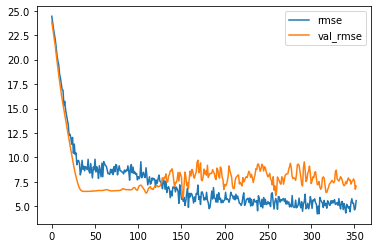

In [15]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mse']), np.sqrt(metrics['val_mse']))
plt.legend(['rmse', 'val_rmse'])
plt.show()

In [16]:
np.sqrt(model.evaluate(val_ds.batch(batch_size)))

1/1 [==============================] - 0s 134ms/step - loss: 50.0546 - mse: 50.0546


array([7.07492916, 7.07492916])

In [17]:
np.sqrt(model.evaluate(test_ds.batch(batch_size)))

1/1 [==============================] - 1s 810ms/step - loss: 109.4740 - mse: 109.4740


array([10.46298268, 10.46298268])

In [18]:
model.predict(preprocess_dataset([train_files[0]]).batch(30), verbose=2)

1/1 - 1s


array([[20.079771]], dtype=float32)

In [19]:
model.predict(get_data(train_files[0])[0])

array([[20.079771],
       [16.81776 ],
       [26.318089],
       [25.99425 ],
       [17.146868],
       [25.386007],
       [25.345251],
       [23.555567],
       [23.917797],
       [26.248844],
       [23.004177],
       [20.153202],
       [18.384935],
       [14.327631],
       [16.310162],
       [14.993082],
       [16.223171],
       [23.05632 ],
       [18.316576],
       [14.628019],
       [19.832985],
       [20.653887],
       [19.2356  ],
       [22.106802],
       [21.76202 ],
       [27.827068],
       [19.584213],
       [24.999395],
       [16.44311 ],
       [24.052725]], dtype=float32)

In [20]:
get_data(train_files[5])[1]

<tf.Tensor: shape=(), dtype=int64, numpy=27>

In [21]:
meta = meta.assign(split = '', predict = -99.99, predict_group = 'cc')
for file in train_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'train'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in test_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'test'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in val_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'val'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'

In [22]:
meta.predict.describe()

count    108.000000
mean      21.874337
std        3.091948
min       12.087054
25%       19.397238
50%       21.977011
75%       24.219676
max       28.058397
Name: predict, dtype: float64

In [23]:
from sklearn.metrics import confusion_matrix, mean_squared_error
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

,split,rmse
0,test,8.756286
1,train,6.054662
2,val,6.873691


In [24]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

,Gender,rmse
0,female,7.288521
1,male,5.812098


In [25]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict'] ))

6.672785581978311

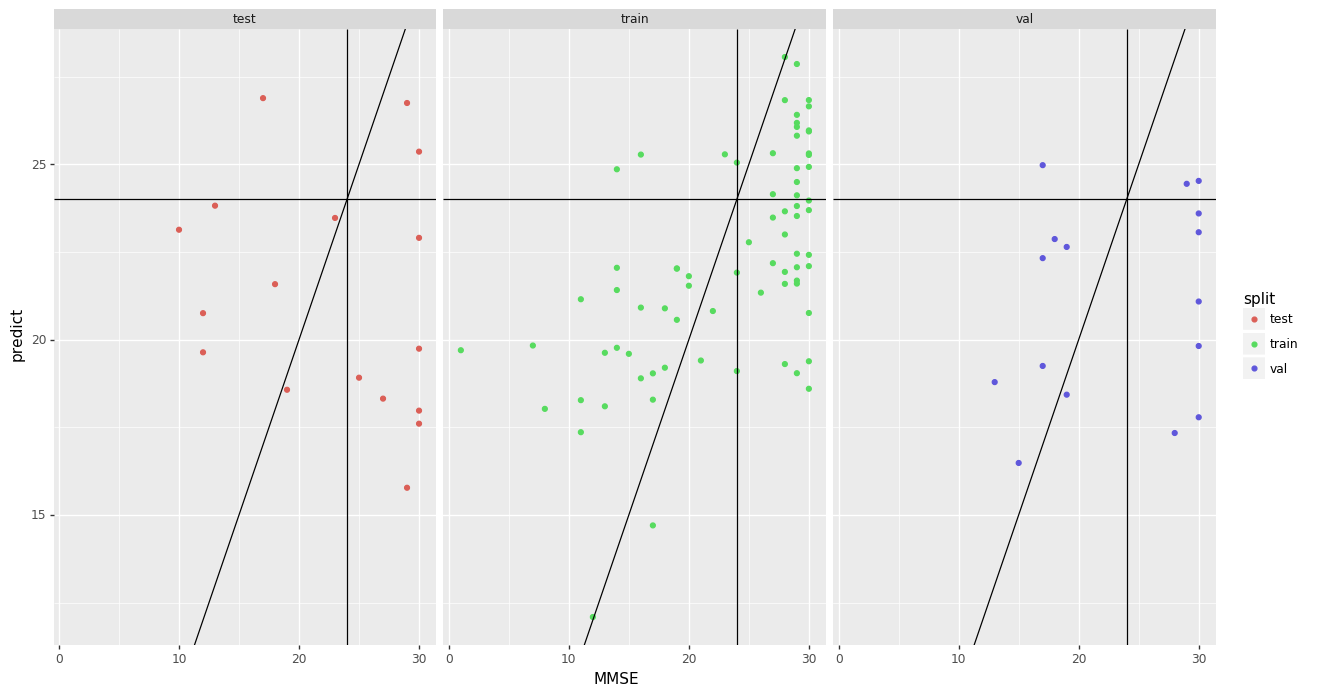

<ggplot: (-9223363283810958560)>

In [26]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

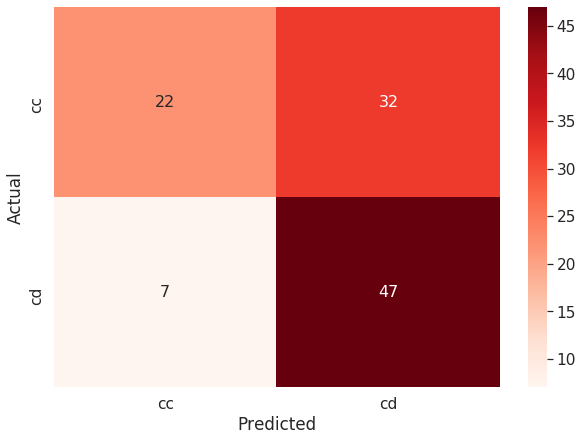

In [27]:
y_true = meta.Group
y_pred = meta.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [28]:
model.save('saved_model/base_line/20210225')

INFO:tensorflow:Assets written to: saved_model/base_line/20210225/assets


INFO:tensorflow:Assets written to: saved_model/base_line/20210225/assets
